In [2]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling1D, Dropout, LSTM, Dense


In [ ]:
class WorkoutModelTrainer:
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.X = None
        self.y = None
        self.class_mapping = None
        self.confidences = None
        self.model = None
        self.load_data()
        
    def load_data(self):
        print("Loading preprocessed data...")
        self.X = np.load(os.path.join(self.data_dir, 'X.npy'))
        self.y = np.load(os.path.join(self.data_dir, 'y.npy'))
        self.confidences = np.load(os.path.join(self.data_dir, 'confidences.npy'))
        self.class_mapping = np.load(os.path.join(self.data_dir, 'class_mapping.npy'),
                                   allow_pickle=True).item()
        
        print(f"Loaded {len(self.X)} samples")
        print(f"Input shape: {self.X.shape}")  # Added to verify shape
        print("\nClass distribution:")
        for class_name, class_idx in self.class_mapping.items():
            total = sum(1 for label in self.y if label == class_idx)
            print(f"{class_name}: {total} samples")
            
    def build_model(self, input_shape, num_classes):
        model = tf.keras.Sequential([
            Conv1D(64, kernel_size=3, padding='same', activation='relu',
                  kernel_regularizer=tf.keras.regularizers.l2(0.01)), 
            BatchNormalization(),
            MaxPooling1D(pool_size=2),
            Dropout(0.35),
        
            LSTM(128, return_sequences=True,
                 kernel_regularizer=tf.keras.regularizers.l2(0.01)),
            BatchNormalization(),
            Dropout(0.35),
        
            LSTM(64, kernel_regularizer=tf.keras.regularizers.l2(0.01)),
            BatchNormalization(),
            Dropout(0.35),
        
            Dense(64, activation='relu',
                 kernel_regularizer=tf.keras.regularizers.l2(0.01)),
            BatchNormalization(),
            Dropout(0.3),
        
            Dense(num_classes, activation='softmax')
        ])
    
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003)
    
        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        
        # Print model summary with new input shape
        print("\nModel Summary:")
        model.build(input_shape=(None,) + input_shape)
        model.summary()
        
        
        return model
        
    def get_callbacks(self):
        class OverfittingDetectionCallback(tf.keras.callbacks.Callback):
            def on_epoch_end(self, epoch, logs={}):
                if logs.get('accuracy') - logs.get('val_accuracy') > 0.2:
                    print("\nWarning: Possible overfitting detected!")
    
        return [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=12,
                restore_best_weights=True,
                min_delta=0.001
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=5,
                min_lr=1e-6,
                verbose=1
            ),
            OverfittingDetectionCallback()
        ]
    
    def calculate_class_weights(self, y_train):
        class_weights = {}
        unique_classes, class_counts = np.unique(y_train, return_counts=True)
        max_count = np.max(class_counts)
        for cls, count in zip(unique_classes, class_counts):
            class_weights[cls] = max_count / count
        return class_weights

    def save_training_plots(self, fold_histories, save_path):
        plot_dir = os.path.join(save_path, 'training_plots')
        os.makedirs(plot_dir, exist_ok=True)
        
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 2, 1)
        for fold, history in enumerate(fold_histories):
            plt.plot(history['accuracy'], label=f'Train (Fold {fold+1})', alpha=0.3)
            plt.plot(history['val_accuracy'], label=f'Val (Fold {fold+1})', alpha=0.3)
        
        plt.title('Model Accuracy Across Folds (Enhanced CNN-LSTM with Weighted Features)')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True)
        
        plt.subplot(1, 2, 2)
        for fold, history in enumerate(fold_histories):
            plt.plot(history['loss'], label=f'Train (Fold {fold+1})', alpha=0.3)
            plt.plot(history['val_loss'], label=f'Val (Fold {fold+1})', alpha=0.3)
        
        plt.title('Model Loss Across Folds (Enhanced CNN-LSTM with Weighted Features)')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True)
        
        plt.tight_layout()
        plt.savefig(os.path.join(plot_dir, 'combined_training_curves.png'), 
                   bbox_inches='tight', dpi=300)
        plt.close()

    def save_fold_results(self, fold_results, fold_histories, save_path):
        results_dir = os.path.join(save_path, 'fold_results')
        os.makedirs(results_dir, exist_ok=True)
        
        all_metrics = []
        for fold, (result, history) in enumerate(zip(fold_results, fold_histories)):
            fold_dir = os.path.join(results_dir, f'fold_{fold+1}')
            os.makedirs(fold_dir, exist_ok=True)
            
            plt.figure(figsize=(15, 5))
            
            plt.subplot(1, 2, 1)
            plt.plot(history['accuracy'], label='Training')
            plt.plot(history['val_accuracy'], label='Validation')
            plt.title(f'Model Accuracy - Fold {fold+1} (Enhanced CNN-LSTM with Weighted Features)')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.legend()
            plt.grid(True)
            
            plt.subplot(1, 2, 2)
            plt.plot(history['loss'], label='Training')
            plt.plot(history['val_loss'], label='Validation')
            plt.title(f'Model Loss - Fold {fold+1} (Enhanced CNN-LSTM with Weighted Features)')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True)
            
            plt.tight_layout()
            plt.savefig(os.path.join(fold_dir, 'training_curves.png'), 
                       bbox_inches='tight', dpi=300)
            plt.close()
            
            plt.figure(figsize=(15, 12))
            sns.heatmap(result['confusion_matrix'], 
                       annot=True, 
                       fmt='d', 
                       cmap='Blues',
                       xticklabels=list(self.class_mapping.keys()),
                       yticklabels=list(self.class_mapping.keys()))
            plt.title(f'Confusion Matrix - Fold {fold+1} (Enhanced CNN-LSTM with Weighted Features)')
            plt.ylabel('True Label')
            plt.xlabel('Predicted Label')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.savefig(os.path.join(fold_dir, 'confusion_matrix.png'), 
                       bbox_inches='tight', dpi=300)
            plt.close()
            
            report_df = pd.DataFrame(result['classification_report']).transpose()
            report_df.to_csv(os.path.join(fold_dir, 'classification_report.csv'))
            
            report_txt = classification_report(
                result['y_true'],
                result['y_pred'],
                target_names=list(self.class_mapping.keys()),
                digits=2,
                zero_division=0
            )
            with open(os.path.join(fold_dir, 'classification_report.txt'), 'w') as f:
                f.write(report_txt)
            
            all_metrics.append({
                'fold': fold + 1,
                'val_accuracy': result['val_accuracy'],
                'val_loss': result['val_loss'],
                'best_epoch': len(history['loss'])
            })
        
        metrics_df = pd.DataFrame(all_metrics)
        metrics_df.to_csv(os.path.join(results_dir, 'all_fold_metrics.csv'), index=False)
        
        avg_metrics = {
            'mean_val_accuracy': metrics_df['val_accuracy'].mean(),
            'std_val_accuracy': metrics_df['val_accuracy'].std(),
            'mean_val_loss': metrics_df['val_loss'].mean(),
            'std_val_loss': metrics_df['val_loss'].std(),
            'mean_epochs': metrics_df['best_epoch'].mean()
        }
        
        pd.DataFrame([avg_metrics]).to_csv(
            os.path.join(results_dir, 'average_metrics.csv'), index=False
        )
        
        print("\nK-Fold Cross Validation Results (Enhanced CNN-LSTM with Weighted Features):")
        print(f"Mean Validation Accuracy: {avg_metrics['mean_val_accuracy']:.4f} ± {avg_metrics['std_val_accuracy']:.4f}")
        print(f"Mean Validation Loss: {avg_metrics['mean_val_loss']:.4f} ± {avg_metrics['std_val_loss']:.4f}")
        print(f"Average Epochs per Fold: {avg_metrics['mean_epochs']:.1f}")

    def train_with_kfold(self, epochs=100, batch_size=16, n_splits=5, save_path=None):
        if save_path is None:
            save_path = "k_fold_CNN_LSTM_landmark"
    
        os.makedirs(save_path, exist_ok=True)
        
        print(f"\nStarting {n_splits}-fold stratified cross validation with Enhanced CNN-LSTM architecture...")
        print(f"Input shape per sample: {self.X.shape[1:]}")
        
        kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        fold_results = []
        fold_histories = []
    
        for fold, (train_idx, val_idx) in enumerate(kfold.split(self.X, self.y)):
            print(f"\nTraining Fold {fold+1}/{n_splits}")
        
            X_train, X_val = self.X[train_idx], self.X[val_idx]
            y_train, y_val = self.y[train_idx], self.y[val_idx]
            
            print("\nClass distribution in validation set:")
            unique, counts = np.unique(y_val, return_counts=True)
            for class_idx, count in zip(unique, counts):
                class_name = list(self.class_mapping.keys())[list(self.class_mapping.values()).index(class_idx)]
                print(f"{class_name}: {count} samples")
        
            input_shape = (X_train.shape[1], X_train.shape[2])
            model = self.build_model(input_shape, len(self.class_mapping))
        
            history = model.fit(
                X_train, y_train,
                validation_data=(X_val, y_val),
                epochs=epochs,
                batch_size=batch_size,
                callbacks=self.get_callbacks(),
                class_weight=self.calculate_class_weights(y_train),
                verbose=1
            )
        
            val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
            y_pred = model.predict(X_val)
            y_pred_classes = np.argmax(y_pred, axis=1)
        
            fold_results.append({
                'val_accuracy': val_accuracy,
                'val_loss': val_loss,
                'confusion_matrix': confusion_matrix(y_val, y_pred_classes),
                'classification_report': classification_report(
                    y_val, y_pred_classes,
                    target_names=list(self.class_mapping.keys()),
                    output_dict=True,
                    zero_division=0
                ),
                'y_true': y_val,
                'y_pred': y_pred_classes
            })

            fold_histories.append(history.history)
            model.save(os.path.join(save_path, f'model_fold_{fold+1}.keras'))
    
        self.save_training_plots(fold_histories, save_path)
        self.save_fold_results(fold_results, fold_histories, save_path)
    
        return fold_results, fold_histories

In [9]:
if __name__ == "__main__":
    # Updated paths to match new data location
    data_dir = r"D:\minor\workout_processed_data_landmark"
    save_path = r"D:\minor\k_fold_CNN_LSTM_landmark"
    
    trainer = WorkoutModelTrainer(data_dir)
    fold_results, fold_histories = trainer.train_with_kfold(
        epochs=100,
        batch_size=16,
        n_splits=5,
        save_path=save_path
    )


Loading preprocessed data...
Loaded 520 samples
Input shape: (520, 45, 297)

Class distribution:
barbell biceps curl: 118 samples
hammer curl: 38 samples
lat pulldown: 92 samples
lateral raise: 74 samples
pull Up: 52 samples
push-up: 112 samples
shoulder press: 34 samples

Starting 5-fold stratified cross validation with Enhanced CNN-LSTM architecture...
Input shape per sample: (45, 297)

Training Fold 1/5

Class distribution in validation set:
barbell biceps curl: 24 samples
hammer curl: 8 samples
lat pulldown: 18 samples
lateral raise: 15 samples
pull Up: 10 samples
push-up: 23 samples
shoulder press: 6 samples

Model Summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 45, 64)            57088     
                                                                 
 batch_normalization (Batch  (None, 45, 64)            256       
 Normalizatio

In [14]:
import tensorflow as tf
import numpy as np
import os
import keras_tuner as kt
from sklearn.model_selection import KFold

# Load data
data_dir = r"D:\minor\workout_processed_data_landmark"
X = np.load(os.path.join(data_dir, 'X.npy'))
y = np.load(os.path.join(data_dir, 'y.npy'))
confidences = np.load(os.path.join(data_dir, 'confidences.npy'))
class_mapping = np.load(os.path.join(data_dir, 'class_mapping.npy'), allow_pickle=True).item()

# Define hyperparameter tuning model
def model_builder(hp):
    model = tf.keras.Sequential([
        Conv1D(
            filters=hp.Choice('filters', [32, 64, 128]), 
            kernel_size=3, 
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.l2(hp.Choice('l2_lambda', [0.001, 0.01, 0.1]))
        ),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(hp.Choice('dropout_rate', [0.3, 0.35, 0.4])),

        LSTM(hp.Choice('lstm_units', [64, 128, 256]), return_sequences=True),
        BatchNormalization(),
        Dropout(hp.Choice('dropout_rate', [0.3, 0.35, 0.4])),

        LSTM(64),
        BatchNormalization(),
        Dropout(0.3),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(7, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', [0.0001, 0.0003, 0.001])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# K-Fold Cross Validation (5 folds)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"\nFold {fold+1}:")

    # Split dataset
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Define Keras Tuner
    tuner = kt.RandomSearch(
        model_builder, 
        objective='val_accuracy', 
        max_trials=10,
        directory="tuner_results",
        project_name=f"fold_{fold+1}"
    )

    # Run hyperparameter tuning
    tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

    # Get best hyperparameters
    best_hyperparameters = tuner.get_best_hyperparameters()[0]
    print("Best hyperparameters:", best_hyperparameters.values)



Fold 1:
Reloading Tuner from tuner_results\fold_1\tuner0.json
Best hyperparameters: {'filters': 32, 'l2_lambda': 0.1, 'dropout_rate': 0.3, 'lstm_units': 256, 'learning_rate': 0.001}

Fold 2:
Reloading Tuner from tuner_results\fold_2\tuner0.json
Best hyperparameters: {'filters': 128, 'l2_lambda': 0.01, 'dropout_rate': 0.4, 'lstm_units': 128, 'learning_rate': 0.0003}

Fold 3:
Reloading Tuner from tuner_results\fold_3\tuner0.json
Best hyperparameters: {'filters': 64, 'l2_lambda': 0.01, 'dropout_rate': 0.35, 'lstm_units': 256, 'learning_rate': 0.001}

Fold 4:
Reloading Tuner from tuner_results\fold_4\tuner0.json
Best hyperparameters: {'filters': 64, 'l2_lambda': 0.01, 'dropout_rate': 0.35, 'lstm_units': 128, 'learning_rate': 0.001}

Fold 5:
Reloading Tuner from tuner_results\fold_5\tuner0.json
Best hyperparameters: {'filters': 128, 'l2_lambda': 0.01, 'dropout_rate': 0.4, 'lstm_units': 256, 'learning_rate': 0.0003}


In [23]:
def build_model(input_shape, num_classes, lstm_units_1=128, lstm_units_2=64):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(64, kernel_size=3, padding='same', activation='relu',
                              kernel_regularizer=tf.keras.regularizers.l2(0.01)), 
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Dropout(0.35),
    
        tf.keras.layers.LSTM(lstm_units_1, return_sequences=True,
                            kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.35),
    
        tf.keras.layers.LSTM(lstm_units_2, kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.35),
    
        tf.keras.layers.Dense(64, activation='relu',
                             kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
    
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003)

    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model
# Example: Define X and y (replace with your actual data)
X = np.load(os.path.join(data_dir, 'X.npy'))
y = np.load(os.path.join(data_dir, 'y.npy'))

In [24]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

# Define a range of LSTM units to test
lstm_units_list = [32, 64, 128]
bias_list = []
variance_list = []

# Use stratified k-fold cross-validation to estimate bias and variance
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for lstm_units in lstm_units_list:
    # Build the model with the current LSTM units
    model = build_model(input_shape=(45, 297), num_classes=7, lstm_units_1=lstm_units, lstm_units_2=lstm_units // 2)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Store predictions for each fold
    predictions = []
    true_labels = []
    
    for train_idx, val_idx in skf.split(X, y):  # y contains integer class labels
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Train the model
        model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)
        
        # Predict on the validation set
        y_pred = model.predict(X_val)
        predictions.append(y_pred)
        true_labels.append(y_val)
    
    # Calculate bias and variance
    predictions = np.array(predictions)  # Shape: (num_folds, num_samples, num_classes)
    true_labels = np.array(true_labels)  # Shape: (num_folds, num_samples)
    
    # Bias: Mean squared error between predicted probabilities and true labels
    # Convert true labels to one-hot encoding for comparison
    true_labels_one_hot = tf.keras.utils.to_categorical(true_labels, num_classes=7)
    bias = np.mean((np.mean(predictions, axis=0) - true_labels_one_hot) ** 2)
    
    # Variance: Variance of predicted probabilities across folds
    variance = np.mean(np.var(predictions, axis=0))
    
    bias_list.append(bias)
    variance_list.append(variance)

4/4 [==============================] - 0s 16ms/step


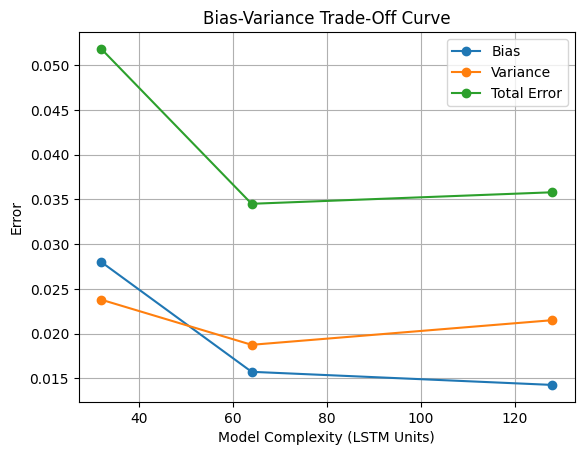

In [25]:
import matplotlib.pyplot as plt

# Calculate total error (bias + variance)
total_error = [b + v for b, v in zip(bias_list, variance_list)]

# Plot the curves
plt.plot(lstm_units_list, bias_list, label='Bias', marker='o')
plt.plot(lstm_units_list, variance_list, label='Variance', marker='o')
plt.plot(lstm_units_list, total_error, label='Total Error', marker='o')

# Add labels and legend
plt.xlabel('Model Complexity (LSTM Units)')
plt.ylabel('Error')
plt.title('Bias-Variance Trade-Off Curve')
plt.legend()
plt.grid()
plt.show()